In [3]:
'''
Generate topics
- from all documents
- prefiltered by tag names

Plots/Prints
- top terms per topic 
- top tags per topic, and their proportion
- heatmap, 2d principal components

Use w2v to test coherence
Classify one document using the generated topics

Make recommendation
- Using other jobs with same topic number 
- ..and same tag?
- ..and highes prob?
'''

'\nGenerate topics\n- from all documents\n- prefiltered by tag names\n\nPlots/Prints\n- top terms per topic \n- top tags per topic, and their proportion\n- heatmap, 2d principal components\n\nUse w2v to test coherence\nClassify one document using the generated topics\n\nMake recommendation\n- Using other jobs with same topic number \n- ..and same tag?\n- ..and highes prob?\n'

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
from numpy.random import rand
from itertools import combinations
import time
import operator
import re
import os
import applicants

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#df_users = applicants.get_applicant_data()

Could not connect to database.
could not connect to server: Operation timed out
	Is the server running on host "db-datasci-20171204.cmyoj5ldbp4q.us-west-2.rds.amazonaws.com" (34.209.61.80) and accepting
	TCP/IP connections on port 5432?



In [3]:
import jobs
df_jobs = jobs.get_job_posting_data()
print df_jobs.shape
docs = df_jobs.description[0:20000]
docs = df_jobs.description

Getting job posting data...
- Time: 0.783392906189

(24015, 5)


In [4]:
# doc_contents = df_jobs.description[20000:20001]
# print doc_contents.iloc[0]

In [5]:
# import topic_model
# tm = topic_model.TopicModeller(model_type='LDA')
# tm.fit(docs, min_df=50, n_topics=10)

In [6]:
import topic_model
min_df = 10
k_topics = 15
max_vocab_size = 5000
ngram_range=(1,1)

tm = topic_model.TopicModeller(model_type='NMF')
tm.fit(docs, max_vocab_size=max_vocab_size, min_df=min_df, k_topics=k_topics)
# Plot a bar chart of top term weights
# topic_num = 1
# n_top_tags = k_topics
# topic_model.plot_top_term_weights(tm.vectorizer.get_feature_names(), tm.H, topic_num, n_top_tags )

Number of documents to process: 24015

Extracting Vectorizer features...
- Time: 8.385s.

Fitting NMF model with TfidfVectorizer features, n_samples=24015 and n_features=5000...
- Time: 15.946s.

Reconstruction mse: 0.000176
Topic 0: office administrative support accounting management data assistant manage assist maintain tasks operations manager financial staff
Topic 1: food kitchen cooking items safety clean quality standards service sanitation equipment production menu orders catering
Topic 2: program services youth community health care families participants agency case clinical treatment staff mental programs
Topic 3: sales store customer retail customers service product products associate manager merchandise merchandising associates inventory fashion
Topic 4: marketing media social design content development communications campaigns business digital creative sales new online events
Topic 5: salon hair stylist stylists spa clients clientele commission nail beauty receptionist cosm

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=200, n_components=15, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [7]:
# Generate the probability of each topic for each row (eg, job posting)
# and add the top topic and probability to the dataframe
def get_normalized_probs(topic_weights):
    '''
    Return the normalized topic cluseter weights for a given row
    '''
    topic_weights = topic_weights.flatten()
    #print row_idx
    probs = (topic_weights / topic_weights.sum())
    return probs

# For each row, get the topic weights, normalize, order by
# weight value, and store in a list to add to the dataframe 
top_topics = []
top_topic_weights = []
for row_idx in range(tm.W.shape[0]):
    W = tm.W[row_idx]
    probs = get_normalized_probs(W)
    
    ordered_idxs = np.argsort(probs)[::-1]
    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    
df_jobs['top_topic'] = top_topics
df_jobs['top_topic_weight'] = top_topic_weights

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [8]:
# Print top n tags for each topic
def get_topic_top_tags(topic_num, n_tags):
    t = df_jobs[df_jobs.top_topic == topic_num].tag_names.value_counts()[:n_tags]
    p = t / t.sum()
    df = t.to_frame(name='tag name count')
    df['tag name proportion'] = p
    return df

n_top_tags = 3
for i in range(df_jobs.top_topic.max()+1):
    tmp_df = get_topic_top_tags(i, n_top_tags)
    print '\nTop tags for topic %s:' % i
    print tmp_df


Top tags for topic 0:
                       tag name count  tag name proportion
Professional Services             498             0.525871
Nonprofit                         346             0.365364
Other                             103             0.108765

Top tags for topic 1:
                           tag name count  tag name proportion
Food & Drink                          961             0.934825
Retail,Food & Drink                    36             0.035019
Family Owned,Food & Drink              31             0.030156

Top tags for topic 2:
                              tag name count  tag name proportion
Nonprofit                                502             0.670227
Community Oriented,Nonprofit             125             0.166889
Nonprofit,Community Oriented             122             0.162884

Top tags for topic 3:
                       tag name count  tag name proportion
Retail                            578             0.729798
Food & Drink                      123 

In [9]:
df_jobs

,id,business_id,title,description,tag_names,top_topic,top_topic_weight
0,1666,35,Barista,Le Marais Bakery is expanding to Ghirardelli S...,Food & Drink,8,0.578984
1,1014,35,Barista,We are seeking baristas for Le Marais Bistro &...,Food & Drink,8,0.412444
2,12909,71,Kitchen Opportunities,Hiring experienced prep/line cooks. 1-2 years ...,Food & Drink,9,0.531150
3,2814,71,Kitchen Positions,Now hiring for full time kitchen positions. &n...,Food & Drink,14,0.631950
4,5417,71,Host/Barista/Server,Staff needed to fill multiple positions: host/...,Food & Drink,9,0.449487
5,3315,71,Server,Looking for a dedicated team player for popula...,Food & Drink,1,0.580815
6,5416,71,Baker for Light Baking Needed,"Baker needed for in house pastries, and other ...",Food & Drink,10,0.352430
7,5419,71,Busser,Looking for very skilled busser/Food runner wi...,Food & Drink,10,0.392690
8,7486,71,Kitchen Opportunities,Hiring experienced Prep/ line cooks/Bussers an...,Food & Drink,9,0.542772
9,4033,71,Prep Cooks,Experienced Prep and Line cooks for busy locat...,Food & Drink,14,0.918170


Topic probabilities:
[ 0.          0.          0.12602009  0.          0.          0.16283642
  0.          0.          0.          0.          0.71114349  0.          0.
  0.          0.        ]

Top Topic: 10

Top Tags:
                       tag name count  tag name proportion
Food & Drink                      763             0.555717
Professional Services             359             0.261471
Retail                            251             0.182811



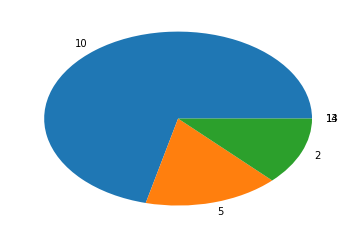

In [52]:
# Inspect record data
def inspect_record(rec_id):
    row_num = rec_id
    probs = get_normalized_probs(tm.W[row_num])
    ordered_idxs = np.argsort(probs)[::-1]
    top_topic = ordered_idxs[0]
    print "Topic probabilities:\n%s\n" % probs
    print "Top Topic: %s\n" % top_topic
    print "Top Tags:\n%s\n" % get_topic_top_tags(top_topic, 3)

    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    plt.pie(probs[ordered_idxs[:5]], labels=ordered_idxs[:5])
    #print df_jobs.iloc[row_num].description
inspect_record(4033)

(967,)
(9306,)
(500,)


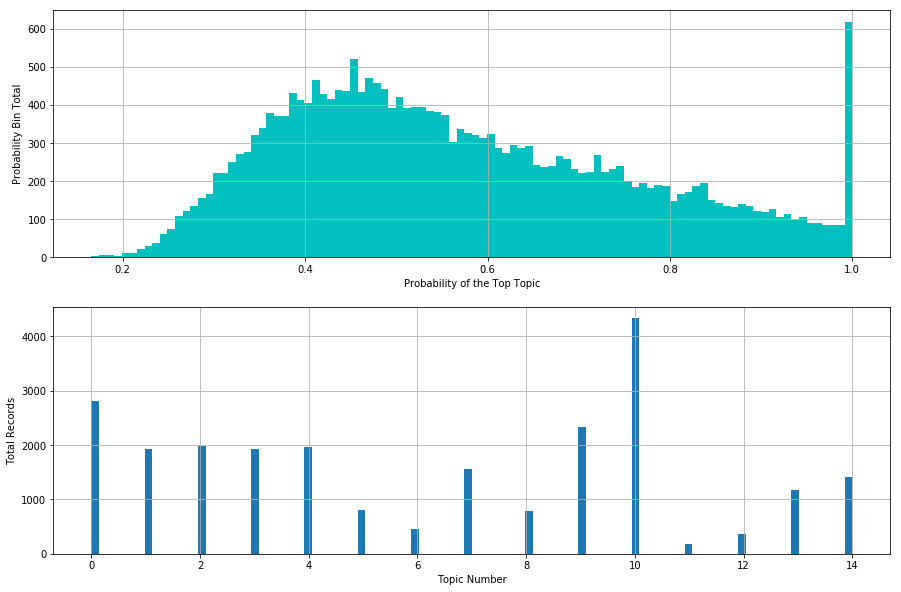

In [11]:
# Plot/Print topic probablity distributions and counts
print df_jobs.top_topic_weight[df_jobs.top_topic_weight < .3].shape
print df_jobs.top_topic_weight[df_jobs.top_topic_weight > .6].shape
print df_jobs.top_topic_weight[df_jobs.top_topic_weight == 1].shape
# print df_jobs.top_topic_weight[df_jobs.top_topic_weight == 1]

plt.figure(figsize=(15,5))
fig, axarr = plt.subplots(2, 1, figsize=(15,10))
axarr[0].set_xlabel('Probability of the Top Topic')
axarr[0].set_ylabel('Probability Bin Total')
df_jobs.top_topic_weight.hist(ax=axarr[0], bins=100, color='c')
axarr[1].set_xlabel('Topic Number')
axarr[1].set_ylabel('Total Records')
df_jobs.top_topic.hist(ax=axarr[1], bins=100)

In [51]:
# Given a record, recommend another record
# Flexible logic here...
def make_recommendation(job_id):
    # Get the input job's topic
    topic = df_jobs[df_jobs.id == job_id].top_topic
    print 'Topic: %s' % topic
    source_prob = df_jobs[df_jobs.id == job_id].top_topic_weight.values[0]
    source_title = df_jobs[df_jobs.id == job_id].title.values[0]
    print 'Source job %s (prob %s)' % (job_id, source_prob)
    
    # Filter
    topic_records = df_jobs[(df_jobs.top_topic == int(topic))]
    # Get all records with that topic with high weight
    #topic_records = df_jobs[(df_jobs.top_topic == int(topic)) & (df_jobs.top_topic_weight > .85)]
    # Get all records with that topic and title
    #topic_records = df_jobs[(df_jobs.top_topic == int(topic)) & (df_jobs.title == source_title)]
    
    print 'Num records after filter:',topic_records.shape
    
    # Pick one at random
    r = np.random.randint(low=0, high=topic_records.shape[0]-1)
    rec_id = topic_records.iloc[r].id
    rec_prob = df_jobs[df_jobs.id == rec_id].top_topic_weight.values[0]
    print 'Recommending job %s (prob %s)' % (rec_id, rec_prob)
    return topic_records.iloc[r].id

job_id = 4033
rec_id = make_recommendation(job_id)
print 'Source:'
print '- title: %s' % df_jobs[df_jobs.id == job_id].title.values[0]
print '- desc: %s' % df_jobs[df_jobs.id == job_id].description.values[0][:100]
print 'Rec:'
print '- title: %s' % df_jobs[df_jobs.id == rec_id].title.values[0]
print '- desc: %s' % df_jobs[df_jobs.id == rec_id].description.values[0][:100]


Topic: 9    14
Name: top_topic, dtype: int64
Source job 4033 (prob 0.91817032465)
Num records after filter: (1416, 7)
Recommending job 3525 (prob 0.258920328131)
Source:
- title: Prep Cooks
- desc: Experienced Prep and Line cooks for busy location. &nbsp;Must be&nbsp;available mornings and Saturda
Rec:
- title: Cooks
- desc: We are seeking two part time cooks
brunch sat and sunday 830-3pm
dinner mon wed thurs 3pm-close

Or 


In [32]:
terms = tm.vectorizer.get_feature_names()
term_ranks = tm.rank_terms( tm.document_term_mat, terms)

top_n = 20
print "Top %s terms across all %s terms (ranked by the term's vector tfidf sum):" % (top_n, len(terms))
for i, pair in enumerate( term_ranks[0:top_n] ):
    print( "  %02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

Top 20 terms across all 5000 terms (ranked by the term's vector tfidf sum):
  01. food (639.26)
  02. service (623.10)
  03. customer (550.01)
  04. restaurant (478.22)
  05. sales (442.45)
  06. staff (431.58)
  07. environment (427.12)
  08. program (413.06)
  09. school (405.20)
  10. years (369.86)
  11. office (357.17)
  12. management (352.85)
  13. kitchen (349.77)
  14. customers (347.35)
  15. support (345.89)
  16. knowledge (342.55)
  17. community (339.67)
  18. children (337.46)
  19. provide (332.30)
  20. new (330.43)


Applying NMF for k=3 ...
- Time: 3.361s.
Applying NMF for k=4 ...
- Time: 3.399s.
Applying NMF for k=5 ...
- Time: 3.850s.
Applying NMF for k=6 ...
- Time: 4.434s.
Applying NMF for k=7 ...
- Time: 5.197s.
Applying NMF for k=8 ...
- Time: 5.907s.
Applying NMF for k=9 ...
- Time: 6.541s.
Applying NMF for k=10 ...
- Time: 6.958s.
Applying NMF for k=11 ...
- Time: 7.380s.
Applying NMF for k=12 ...
- Time: 5.831s.
Applying NMF for k=13 ...
- Time: 7.538s.
Applying NMF for k=14 ...
- Time: 14.528s.
Applying NMF for k=15 ...
- Time: 13.779s.
Applying NMF for k=16 ...
- Time: 9.975s.
Applying NMF for k=17 ...
- Time: 8.658s.
Applying NMF for k=18 ...
- Time: 17.729s.
Applying NMF for k=19 ...
- Time: 19.877s.
Applying NMF for k=20 ...
- Time: 11.986s.
No Word2Vec model found at './data/w2v-model.bin' to load ([Errno 2] No such file or directory: './data/w2v-model.bin')
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2

Topic 13: 15 top words: [u'children', u'teacher', u'child', u'preschool', u'early', u'childhood', u'teachers', u'school', u'classroom', u'units', u'education', u'ece', u'care', u'development', u'teaching']
K=14: Coherence=0.2297

Topic 0: 15 top words: [u'office', u'administrative', u'support', u'accounting', u'management', u'data', u'assistant', u'manage', u'assist', u'maintain', u'tasks', u'operations', u'manager', u'financial', u'staff']
Topic 1: 15 top words: [u'food', u'kitchen', u'cooking', u'items', u'safety', u'clean', u'quality', u'standards', u'service', u'sanitation', u'equipment', u'production', u'menu', u'orders', u'catering']
Topic 2: 15 top words: [u'program', u'services', u'youth', u'community', u'health', u'care', u'families', u'participants', u'agency', u'case', u'clinical', u'treatment', u'staff', u'mental', u'programs']
Topic 3: 15 top words: [u'sales', u'store', u'customer', u'retail', u'customers', u'service', u'product', u'products', u'associate', u'manager', u'm

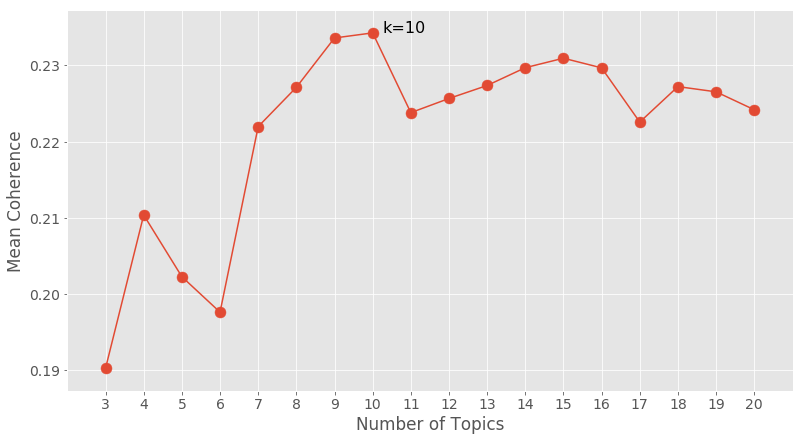

Topic 01: program, services, youth, community, health, care, families, agency, participants, case, clinical, staff, treatment, clients, support
Topic 02: food, kitchen, cook, line, prep, cooking, chef, clean, cooks, items, menu, cleaning, sanitation, quality, safety
Topic 03: children, teacher, child, preschool, early, camp, teachers, childhood, school, classroom, units, education, teaching, care, ece
Topic 04: sales, customer, store, customers, service, retail, product, products, friendly, environment, associate, business, inventory, manager, orders
Topic 05: office, marketing, media, support, design, management, manage, social, administrative, business, development, projects, data, new, project
Topic 06: salon, hair, stylist, spa, stylists, clients, clientele, commission, nail, receptionist, beauty, cosmetology, professional, massage, desk
Topic 07: party, accommodation, staff, staffing, disability, orientation, cross, appointment, hospitality, servers, necessary, bring, interview, e

In [30]:
# Calculate the optimal k using word2vec for coherence metric
topic_model.plot_optimal_k(docs.tolist(), tm.document_term_mat, tm.vectorizer,
                           kmin=3, kmax=20, dim_size=500, min_df=min_df, 
                           max_vocab_size=max_vocab_size, num_top_terms=15,
                           model_file_path='./data/',
                           model_file_name='w2v-model.bin')

In [53]:
# import pdb; pdb.set_trace()
len(tm.vectorizer.get_feature_names())

5000

In [54]:
len(w2v_model.wv.vocab)

4564

In [55]:
docgen = topic_model.TokenGenerator_skl(tm.vectorizer, docs, topic_model.get_stop_words())
w2v_model.build_vocab(docgen, update=True)

Building Word2Vec model ...


In [56]:
'nail' in w2v_model.wv.vocab

False

In [24]:
i = 0
for doc in docgen:
    print i, doc
    print
    i = i+1
    if i > 10:
        break

Building Word2Vec model ...
0 [u'atmosphere', u'square', u'certification', u'expanding', u'coffee', u'existing', u'ghirardelli', u'growth', u'fast', u'sense', u'stumptown', u'genuine', u'knowledge', u'service', u'support', u'marais', u'excel', u'advancement', u'opportunities', u'environment', u'appreciative', u'amazing', u'handler', u'candidates', u'tips', u'setting', u'thrive', u'customers', u'motivated', u'upcoming', u'offer', u'food', u'training', u'expansion', u'roasters', u'requirements', u'post', u'opportunity', u'baristas', u'customer', u'hire', u'welcoming', u'items', u'seeking', u'bakery', u'positions', u'hospitality', u'baked', u'enthusiastic', u'paced']

1 [u'atmosphere', u'traditions', u'handmade', u'knowledge', u'environment', u'forbes', u'candidates', u'health', u'artisanal', u'coffee', u'motivated', u'seeking', u'food', u'familiar', u'rise', u'hailed', u'cond\xe3', u'amp', u'baristas', u'bar', u'positions', u'bay', u'restaurants', u'enjoy', u'attest', u'chef', u'table', 

In [23]:
w2v_model.wv.vocab

{u'limited': <gensim.models.keyedvectors.Vocab at 0x7f2b8b5f7750>,
 u'child': <gensim.models.keyedvectors.Vocab at 0x7f2b8b751e10>,
 u'desirable': <gensim.models.keyedvectors.Vocab at 0x7f2b8b684590>,
 u'facilities': <gensim.models.keyedvectors.Vocab at 0x7f2b8b5f7790>,
 u'consists': <gensim.models.keyedvectors.Vocab at 0x7f2b8b67a050>,
 u'integrity': <gensim.models.keyedvectors.Vocab at 0x7f2b8b6845d0>,
 u'relationships': <gensim.models.keyedvectors.Vocab at 0x7f2b8b684610>,
 u'instructor': <gensim.models.keyedvectors.Vocab at 0x7f2b8b5e6d50>,
 u'eligible': <gensim.models.keyedvectors.Vocab at 0x7f2ba7ae7290>,
 u'disability': <gensim.models.keyedvectors.Vocab at 0x7f2b8b67a090>,
 u'bike': <gensim.models.keyedvectors.Vocab at 0x7f2b8b684650>,
 u'teaching': <gensim.models.keyedvectors.Vocab at 0x7f2b8b67a0d0>,
 u'pride': <gensim.models.keyedvectors.Vocab at 0x7f2b8b5f77d0>,
 u'restock': <gensim.models.keyedvectors.Vocab at 0x7f2b8b684690>,
 u'silicon': <gensim.models.keyedvectors.Vocab 

In [23]:
docgen = topic_model.TokenGenerator(docs, topic_model.get_stop_words())

In [37]:
doc = docs.tolist()[0]
fa = tm.vectorizer.build_analyzer()
fp = tm.vectorizer.build_preprocessor()
ft = tm.vectorizer.build_tokenizer()

fa(fp(doc))
sw = topic_model.get_stop_words()
# lst_pre = [fa(fp(doc)) for doc in docs.tolist()]
# lst = [word for word in lst_pre if word not in sw]
# lst_pre = [list(set(fa(fp(doc)))-set(sw)) for doc in docs.tolist()]

In [35]:
#lst = [w for w in lst_pre if w not in sw]
all_tokens = []
for doc in docs.tolist():
    # tokens = fa(fp(doc))
    tokens = list(set(fa(fp(doc)))-set(sw))
    tokens = [t for t in tokens if len(t) > 2]
    all_tokens.append(tokens)

In [36]:
all_tokens[0]

[u'atmosphere',
 u'square',
 u'certification',
 u'expanding',
 u'coffee',
 u'existing',
 u'ghirardelli',
 u'growth',
 u'fast',
 u'sense',
 u'stumptown',
 u'genuine',
 u'knowledge',
 u'service',
 u'support',
 u'marais',
 u'excel',
 u'advancement',
 u'opportunities',
 u'environment',
 u'appreciative',
 u'amazing',
 u'handler',
 u'candidates',
 u'tips',
 u'setting',
 u'thrive',
 u'customers',
 u'motivated',
 u'upcoming',
 u'offer',
 u'food',
 u'training',
 u'expansion',
 u'roasters',
 u'requirements',
 u'post',
 u'opportunity',
 u'baristas',
 u'customer',
 u'hire',
 u'welcoming',
 u'items',
 u'seeking',
 u'bakery',
 u'positions',
 u'hospitality',
 u'baked',
 u'enthusiastic',
 u'paced']

In [23]:
topic_model.get_stop_words()

frozenset({'a',
           'ability',
           'able',
           'about',
           'above',
           'accomplish',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'alameda',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'applicants',
           'application',
           'apply',
           'are',
           'around',
           'as',
           'at',
           'available',
           'ave',
           'b',
           'back',
           'be',
           'became',
           'because',
           'beco

In [21]:
lst[100]

[u'home',
 u'services',
 u'hands',
 u'mr',
 u'sparkle',
 u'window',
 u'washers',
 u'window',
 u'cleaners',
 u'mon',
 u'sat',
 u'primarily',
 u'residential',
 u'small',
 u'commercial',
 u'east',
 u'bay',
 u'services',
 u'window',
 u'washing',
 u'pressure',
 u'washing',
 u'gutter',
 u'cleaning',
 u'pride',
 u'green',
 u'certified',
 u'business',
 u'forward',
 u'thinking',
 u'providing',
 u'quality',
 u'right',
 u'applicant',
 u'oriented',
 u'physically',
 u'fit',
 u'genuinely',
 u'friendly',
 u'tools',
 u'transport',
 u'supplied',
 u'business',
 u'mr',
 u'sparkle',
 u'window',
 u'washers',
 u'clean',
 u'culture',
 u'reflected',
 u'window',
 u'clean',
 u'crews',
 u'happy',
 u'trained',
 u'measure',
 u'success',
 u'loyalty',
 u'clients',
 u'compensation',
 u'cleaners',
 u'years',
 u'start',
 u'year',
 u'benefits',
 u'paid',
 u'earned',
 u'hour',
 u'health',
 u'benefits',
 u'offered',
 u'employees',
 u'driver',
 u'license',
 u'clean',
 u'dmv',
 u'lift',
 u'comfortable',
 u'ladder',
 u'early

In [4]:
# for doc in docgen:
#     print doc

In [25]:
# w2v_model.wv.similarity('aa','aap')
v = w2v_model.wv.vocab
print 'v len', len(v)
'summit' in v

v len 2310


False

In [31]:
print len(w2v_model.wv.vocab)
print len(terms)
'summit' in terms

11402
5000


True

In [19]:
try:
    some_object = doc_contents.iloc[0]
    some_object_iterator = iter(some_object)
except TypeError, te:
    print some_object, 'is not iterable'

In [75]:
import numpy as np
#doc_contents = df_jobs.description[20000:20001]
doc_contents = df_jobs.description.iloc[21]

#document_term_mat = tm.vectorizer.transform(['• The House approved the most sweeping tax rewrite in decades mostly along party lines, with lawmakers voting 227-203.• The action has now moved to the Senate, which is expected to vote on the bill, possibly on Tuesday evening.'])
document_term_mat = tm.vectorizer.transform([doc_contents])
W = tm.model.transform(document_term_mat)
H = tm.model.components_

print W.shape
print H.shape
print 'W:', W
probs = W / W.sum(axis=1, keepdims=True)
print 'W probs:', probs
print
print 'H:', H

print np.argsort(W)[0][::-1]

#print doc_contents.iloc[0]
print doc_contents

(1, 15)
(15, 5000)
W: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.07323004]]
W probs: [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

H: [[ 0.03295516  0.05688226  0.         ...,  0.          0.          0.04571478]
 [ 0.          0.          0.         ...,  0.          0.          0.00202479]
 [ 0.          0.          0.         ...,  0.          0.00651104  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
Bissab baobab in SF is looking for someone to join the crew! &nbsp;We are hiring a line cook !


In [50]:
# from nltk.stem.porter import PorterStemmer
# def stemmed_words(doc):
#     stemmer = PorterStemmer()
#     analyzer = CountVectorizer().build_analyzer()
#     return (stemmer.stem(w) for w in analyzer(doc))

# vectorizer = TfidfVectorizer(token_pattern=topic_model.get_token_pattern(),
#                                   min_df=min_df,
#                                   max_features=max_vocab_size,
#                                   stop_words=topic_model.get_stop_words(),
#                                   ngram_range=ngram_range,
#                                   #analyzer=stemmed_words
#                                   tokenizer=topic_model.TokenGenerator_skl()
#                                   )

# model = NMF(n_components=k_topics,
#                  alpha=.1, l1_ratio=.5, init='nndsvd')

# print "Extracting Vectorizer features..."
# t1 = time.time()
# document_term_mat = vectorizer.fit_transform(docs)
# print "- Time: %0.3fs.\n" % (time.time() - t1)

# print "Fitting %s model with %s features, " \
#       "n_samples=%d and n_features=%d..." \
#       % ('NMF', vectorizer.__class__.__name__,
#          docs.shape[0], max_vocab_size)
# t1 = time.time()
# W = model.fit_transform(document_term_mat)
# H = model.components_
# print "- Time: %0.3fs.\n" % (time.time() - t1)
# tm.describe_matrix_factorization_results(document_term_mat, W, H)
